In [2]:
# Core ML Libraries
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    Input,
    Embedding,
    LSTM,
    Dense,
    Dropout,
    Bidirectional,
    Layer,
    Lambda,
    Concatenate,
    LayerNormalization
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Data Processing
import numpy as np
import pandas as pd
import json
import re
import os
import random
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from rouge_score import rouge_scorer

# Visualization
import matplotlib.pyplot as plt

# Progress Bar Utility
from tqdm import tqdm

# Necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import wordnet

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# Bidirectional LSTM with attention

## Data Preprocessing

In [3]:
MAX_QUESTION_LENGTH = 50
MAX_ANSWER_LENGTH = 200
EMBEDDING_DIM = 384
LATENT_DIM = 768
BATCH_SIZE = 64
EPOCHS = 40
VALIDATION_SPLIT = 0.2
TEST_SPLIT = 0.2
LEARNING_RATE = 1e-4
CLIP_NORM = 1.0
BEAM_WIDTH = 3
TEMPERATURE = 1.0

In [4]:
def augment_data(question, answer):
    augmented_pairs = []
    # Original pair
    augmented_pairs.append((question, answer))

    # Remove punctuation version
    q_no_punct = re.sub(r'[.,!?]', '', question)
    augmented_pairs.append((q_no_punct, answer))

    # Shuffle words slightly (maintaining rough meaning)
    words = question.split()
    if len(words) > 3:
        for i in range(min(3, len(words)-1)):
            shuffled = words.copy()
            shuffled[i], shuffled[i+1] = shuffled[i+1], shuffled[i]
            augmented_pairs.append((' '.join(shuffled), answer))

    return augmented_pairs

def get_synonyms(word):
    try:
        synonyms = []
        for syn in wordnet.synsets(word):
            for lemma in syn.lemmas():
                if lemma.name() != word and '_' not in lemma.name():
                    synonyms.append(lemma.name())
        return list(set(synonyms))
    except LookupError:
        nltk.download('wordnet')
        return get_synonyms(word)
    except Exception as e:
        print(f"Synonym error: {str(e)}")
        return []

def advanced_augment_data(question, answer, augmentation_factor=3):
    """
    Simplified augmentation without async operations
    """
    augmented_pairs = [(question, answer)]

    # 1. Synonym replacement
    words = question.split()
    for _ in range(min(3, len(words))):
        new_words = words.copy()
        idx = random.randint(0, len(words)-1)
        synonyms = get_synonyms(words[idx])
        if synonyms:
            new_words[idx] = random.choice(synonyms)
            augmented_pairs.append((' '.join(new_words), answer))

    # 2. Random deletion
    if len(words) > 4:
        new_words = [word for word in words if random.random() > 0.2]
        if new_words:
            augmented_pairs.append((' '.join(new_words), answer))

    # 3. Word order variations
    if len(augmented_pairs) < augmentation_factor:
        if len(words) > 3:
            for i in range(min(2, len(words)-1)):
                shuffled = words.copy()
                shuffled[i], shuffled[i+1] = shuffled[i+1], shuffled[i]
                augmented_pairs.append((' '.join(shuffled), answer))

    # 4. Remove punctuation version
    q_no_punct = re.sub(r'[.,!?]', '', question)
    if q_no_punct != question:
        augmented_pairs.append((q_no_punct, answer))

    return augmented_pairs[:augmentation_factor]

def load_data(dataset_path):
    data = []
    for file in sorted(os.listdir(dataset_path)):
        if file.endswith(".json"):
            with open(os.path.join(dataset_path, file), "r", encoding="utf-8") as f:
                content = json.load(f)
                qa_pairs = content.get("qa_pairs", [])
                for pair in qa_pairs:
                    augmented = augment_data(pair["question"], pair["answer"])
                    for q, a in augmented:
                        data.append({"question": q, "answer": a})
    return pd.DataFrame(data)

def improved_clean_text(text):
    """Enhanced text cleaning with better special character handling"""
    text = text.lower().strip()
    # Preserve more meaningful punctuation and symbols
    text = re.sub(r'[^\w\s.,!?\'"-:;$%#@&*()]', ' ', text)
    # Normalize numbers
    text = re.sub(r'\d+', 'NUM', text)
    # Normalize spaces
    text = re.sub(r'\s+', ' ', text)
    return f"<START> {text} <END>"

def preprocess_data(df):
    df["question"] = df["question"].apply(improved_clean_text)
    df["answer"] = df["answer"].apply(improved_clean_text)

    # Create tokenizers with additional special tokens
    question_tokenizer = Tokenizer(oov_token="<UNK>", filters='')
    answer_tokenizer = Tokenizer(oov_token="<UNK>", filters='')

    # Add padding token
    question_tokenizer.word_index['<PAD>'] = 0
    answer_tokenizer.word_index['<PAD>'] = 0

    # Fit tokenizers
    question_tokenizer.fit_on_texts(df["question"])
    answer_tokenizer.fit_on_texts(df["answer"])

    # Convert to sequences
    question_sequences = question_tokenizer.texts_to_sequences(df["question"])
    answer_sequences = answer_tokenizer.texts_to_sequences(df["answer"])

    # Pad sequences
    question_padded = pad_sequences(question_sequences, maxlen=MAX_QUESTION_LENGTH, padding='post')
    answer_padded = pad_sequences(answer_sequences, maxlen=MAX_ANSWER_LENGTH, padding='post')

    return question_padded, answer_padded, question_tokenizer, answer_tokenizer

## Model Building

In [5]:
@tf.keras.utils.register_keras_serializable()
class BahdanauAttention(Layer):
    def __init__(self, units, **kwargs):
        super(BahdanauAttention, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.W1 = self.add_weight(
            shape=(input_shape[0][-1], self.units),
            initializer='glorot_uniform',
            name='W1'
        )
        self.W2 = self.add_weight(
            shape=(input_shape[1][-1], self.units),
            initializer='glorot_uniform',
            name='W2'
        )
        self.V = self.add_weight(
            shape=(self.units, 1),
            initializer='glorot_uniform',
            name='V'
        )
        super(BahdanauAttention, self).build(input_shape)

    def call(self, inputs):
        decoder_hidden_states, encoder_outputs = inputs

        # Transform states
        decoder_hidden = tf.tensordot(decoder_hidden_states, self.W1, axes=[[2], [0]])
        encoder_hidden = tf.tensordot(encoder_outputs, self.W2, axes=[[2], [0]])

        # Expand dimensions for broadcasting
        decoder_hidden_expanded = tf.expand_dims(decoder_hidden, 2)
        encoder_hidden_expanded = tf.expand_dims(encoder_hidden, 1)

        # Calculate attention
        tanh_output = tf.tanh(decoder_hidden_expanded + encoder_hidden_expanded)
        attention_weights = tf.tensordot(tanh_output, self.V, axes=[[3], [0]])
        attention_weights = tf.squeeze(attention_weights, axis=-1)
        attention_weights = tf.nn.softmax(attention_weights, axis=2)

        # Apply attention weights
        context_vector = tf.matmul(attention_weights, encoder_outputs)

        return context_vector, attention_weights

    def get_config(self):
        config = super(BahdanauAttention, self).get_config()
        config.update({
            'units': self.units
        })
        return config

@tf.keras.utils.register_keras_serializable()
class AttentionDecoderLayer(Layer):
    def __init__(self, latent_dim, vocab_size, **kwargs):
        super(AttentionDecoderLayer, self).__init__(**kwargs)
        self.latent_dim = latent_dim
        self.vocab_size = vocab_size

        # Forward and backward LSTMs
        self.forward_lstm = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            recurrent_initializer='glorot_uniform',
            name='forward_lstm'
        )

        self.backward_lstm = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            recurrent_initializer='glorot_uniform',
            go_backwards=True,
            name='backward_lstm'
        )

        # Create layers with proper naming
        self.attention = BahdanauAttention(latent_dim)
        self.concat = Concatenate()
        self.dense1 = Dense(latent_dim * 2, activation='relu')
        self.dropout = Dropout(0.3)
        self.dense2 = Dense(vocab_size, activation='softmax')

    def call(self, inputs, states=None, return_state=False, training=None):
        decoder_inputs, encoder_outputs = inputs

        if states is None:
            # Initialize states with zeros if not provided
            batch_size = tf.shape(decoder_inputs)[0]
            initial_state_h = tf.zeros((batch_size, self.latent_dim))
            initial_state_c = tf.zeros((batch_size, self.latent_dim))
            states = [initial_state_h, initial_state_c, initial_state_h, initial_state_c]

        # Split states for forward and backward LSTM
        forward_h, forward_c, backward_h, backward_c = states

        # Process forward LSTM
        forward_outputs, forward_h_new, forward_c_new = self.forward_lstm(
            decoder_inputs,
            initial_state=[forward_h, forward_c]
        )

        # Process backward LSTM
        backward_outputs, backward_h_new, backward_c_new = self.backward_lstm(
            decoder_inputs,
            initial_state=[backward_h, backward_c]
        )

        # Combine bidirectional outputs
        decoder_outputs = self.concat([forward_outputs, backward_outputs])

        # Apply attention
        context_vector, _ = self.attention([decoder_outputs, encoder_outputs])

        # Combine context with decoder outputs
        decoder_combined = self.concat([decoder_outputs, context_vector])

        # Process through dense layers
        outputs = self.dense1(decoder_combined)
        outputs = self.dropout(outputs, training=training)
        outputs = self.dense2(outputs)

        if return_state:
            new_states = [forward_h_new, forward_c_new, backward_h_new, backward_c_new]
            return outputs, new_states
        return outputs

    def get_config(self):
        config = super(AttentionDecoderLayer, self).get_config()
        config.update({
            'latent_dim': self.latent_dim,
            'vocab_size': self.vocab_size
        })
        return config

custom_objects = {
    'BahdanauAttention': BahdanauAttention,
    'AttentionDecoderLayer': AttentionDecoderLayer
}

def build_improved_model(vocab_size_q, vocab_size_a):
    """Build the main training model with consistent layer naming"""
    # Encoder
    encoder_inputs = Input(shape=(MAX_QUESTION_LENGTH,), dtype=tf.float32, name='encoder_inputs')

    encoder_embedding = Embedding(
        vocab_size_q,
        EMBEDDING_DIM,
        mask_zero=True,
        name='encoder_embedding'
    )(encoder_inputs)

    encoder_dropout = Dropout(0.3, name='encoder_dropout')(encoder_embedding)

    # Bidirectional encoder - explicit naming
    encoder_bilstm = Bidirectional(
        LSTM(
            LATENT_DIM,
            return_sequences=True,
            return_state=True,
            recurrent_initializer='glorot_uniform'
        ),
        name='encoder_bilstm'
    )

    encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_bilstm(encoder_dropout)

    # Combine states
    state_h = Concatenate(name='encoder_state_h_concat')([forward_h, backward_h])
    state_c = Concatenate(name='encoder_state_c_concat')([forward_c, backward_c])

    # Decoder
    decoder_inputs = Input(shape=(None,), dtype=tf.float32, name='decoder_inputs')

    decoder_embedding = Embedding(
        vocab_size_a,
        EMBEDDING_DIM,
        mask_zero=True,
        name='decoder_embedding'
    )(decoder_inputs)

    decoder_dropout = Dropout(0.3, name='decoder_dropout')(decoder_embedding)

    # Create and apply decoder with explicit naming
    decoder_layer = AttentionDecoderLayer(LATENT_DIM, vocab_size_a, name='attention_decoder_layer')
    decoder_outputs = decoder_layer(
        [decoder_dropout, encoder_outputs],
        states=[forward_h, forward_c, backward_h, backward_c]
    )

    # Create model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    # Compile
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=LEARNING_RATE,
        clipnorm=CLIP_NORM
    )

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    print(model.summary())

    return model

In [6]:
def create_inference_models(model, vocab_size_a):
    """Create encoder and decoder models for inference"""

    # Encoder
    encoder_inputs = model.input[0]  # Get encoder inputs from training model

    # Get encoder layers
    encoder_embedding = model.get_layer('encoder_embedding')
    encoder_lstm = model.get_layer('encoder_bilstm')  # Get the bidirectional layer

    # Create encoder model
    encoder_embedded = encoder_embedding(encoder_inputs)
    encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm(encoder_embedded)

    # Combine states
    state_h = Concatenate()([forward_h, backward_h])
    state_c = Concatenate()([forward_c, backward_c])

    encoder_model = Model(
        inputs=encoder_inputs,
        outputs=[encoder_outputs, state_h, state_c]
    )

    # Decoder setup for inference
    decoder_inputs = Input(shape=(1,))
    encoder_states_inputs = [
        Input(shape=(MAX_QUESTION_LENGTH, LATENT_DIM * 2)),  # encoder_outputs
        Input(shape=(LATENT_DIM * 2,)),  # state_h
        Input(shape=(LATENT_DIM * 2,))   # state_c
    ]

    # Get decoder layers
    decoder_embedding = model.get_layer('decoder_embedding')
    decoder_lstm = model.get_layer('attention_decoder_layer')

    # Process through decoder
    decoder_embedded = decoder_embedding(decoder_inputs)

    # Split states for bidirectional decoder
    decoder_lstm_dim = LATENT_DIM
    states_h = encoder_states_inputs[1]
    states_c = encoder_states_inputs[2]

    forward_h = Lambda(lambda x: x[:, :decoder_lstm_dim])(states_h)
    forward_c = Lambda(lambda x: x[:, :decoder_lstm_dim])(states_c)
    backward_h = Lambda(lambda x: x[:, decoder_lstm_dim:])(states_h)
    backward_c = Lambda(lambda x: x[:, decoder_lstm_dim:])(states_c)

    decoder_outputs = decoder_lstm(
        [decoder_embedded, encoder_states_inputs[0]],
        states=[forward_h, forward_c, backward_h, backward_c],
        training=False
    )

    decoder_model = Model(
        inputs=[decoder_inputs] + encoder_states_inputs,
        outputs=decoder_outputs
    )

    return encoder_model, decoder_model

In [7]:
def optimized_beam_search_decode(encoder_model, decoder_model, input_seq, a_tokenizer,
                               beam_width=3, max_length=50, temperature=1.0,
                               early_stopping_threshold=0.001):
    """
    Optimized beam search decoding with fixed tensor shapes
    """
    # Ensure input_seq is a tensor with correct shape
    input_seq = tf.convert_to_tensor(input_seq)
    if len(input_seq.shape) == 1:
        input_seq = tf.expand_dims(input_seq, 0)

    # Get encoder outputs
    encoder_outputs, state_h, state_c = encoder_model(input_seq, training=False)

    # Initialize beam search
    start_token = a_tokenizer.word_index['<start>']
    end_token = a_tokenizer.word_index['<end>']

    initial_beam = ([start_token], 0.0)
    beams = [(initial_beam, (encoder_outputs, state_h, state_c))]
    finished_beams = []

    for _ in range(max_length):
        candidates = []

        for (seq, score), (enc_out, h, c) in beams:
            if seq[-1] == end_token:
                finished_beams.append((seq, score))
                continue

            # Prepare decoder input
            target_seq = tf.convert_to_tensor([[seq[-1]]], dtype=tf.float32)

            # Decoder step
            decoder_outputs = decoder_model(
                [target_seq, enc_out, h, c],
                training=False
            )

            # Get probabilities
            logits = decoder_outputs[0, -1, :]
            probs = tf.nn.softmax(logits / temperature).numpy()

            # Get top k candidates
            top_k_probs, top_k_indices = tf.nn.top_k(probs, k=beam_width)

            for prob, idx in zip(top_k_probs.numpy(), top_k_indices.numpy()):
                new_seq = seq + [idx]
                new_score = score + float(tf.math.log(prob + 1e-10))
                candidates.append(
                    ((new_seq, new_score), (enc_out, h, c))
                )

        # Early stopping check
        if finished_beams:
            best_finished_score = max(score for _, score in finished_beams)
            candidates = [c for c in candidates
                        if c[0][1] + early_stopping_threshold >= best_finished_score]

        # Select top beams
        beams = sorted(candidates, key=lambda x: x[0][1], reverse=True)[:beam_width]

        # Break if all beams finished
        if all(beam[0][0][-1] == end_token for beam in beams):
            break

    # Get best sequence
    if finished_beams:
        best_seq = max(finished_beams, key=lambda x: x[1])[0]
    else:
        best_seq = max(beams, key=lambda x: x[0][1])[0][0]

    return best_seq  # Return the highest scoring sequence

# Training history plotting
def plot_training_history(history):
    """
    Plot training metrics and learning rate
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Loss plot
    axes[0, 0].plot(history.history['loss'], label='Training Loss')
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 0].set_title('Model Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()

    # Accuracy plot
    axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0, 1].set_title('Model Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()

    # Learning rate plot
    axes[1, 0].plot(history.history['learning_rate'], label='Learning Rate')
    axes[1, 0].set_title('Learning Rate')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_yscale('log')

    # Clean up and display
    plt.tight_layout()
    plt.show()


In [8]:
def evaluate_model_advanced(encoder_model, decoder_model, q_test, a_test, q_tokenizer, a_tokenizer,
                          beam_width=3, temperature=1.0):
    """
    Enhanced model evaluation with optimized beam search
    """
    smooth = SmoothingFunction().method1
    rouge_scorer_instance = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'])

    # Initialize metrics
    bleu_scores = {f'bleu_{i}': 0.0 for i in range(1, 5)}
    rouge_scores = {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0}

    # Convert test data to tensors once
    q_test = tf.convert_to_tensor(q_test, dtype=tf.float32)

    # Process in batches for efficiency
    batch_size = 32
    for i in range(0, len(q_test), batch_size):
        batch_end = min(i + batch_size, len(q_test))
        batch_q = q_test[i:batch_end]

        references = []
        hypotheses = []

        for j in range(batch_end - i):
            # Get reference tokens
            reference_tokens = [a_tokenizer.index_word.get(idx, '')
                              for idx in a_test[i + j] if idx != 0]
            reference_tokens = [token for token in reference_tokens
                              if token not in ['<start>', '<end>', '<pad>']]
            references.append([reference_tokens])

            # Generate response using optimized beam search
            decoded_sequence = optimized_beam_search_decode(
                encoder_model,
                decoder_model,
                batch_q[j:j+1],
                a_tokenizer,
                beam_width=beam_width,
                temperature=temperature
            )

            decoded_tokens = [a_tokenizer.index_word.get(idx, '')
                            for idx in decoded_sequence
                            if idx not in [a_tokenizer.word_index.get(t, 0)
                                         for t in ['<start>', '<end>', '<pad>']]]
            hypotheses.append(decoded_tokens)

            # Calculate ROUGE scores
            rouge_scores_i = rouge_scorer_instance.score(
                ' '.join(reference_tokens),
                ' '.join(decoded_tokens)
            )
            for key in rouge_scores:
                rouge_scores[key] += rouge_scores_i[key].fmeasure

        # Update BLEU scores for batch
        for i in range(1, 5):
            bleu_scores[f'bleu_{i}'] += corpus_bleu(
                references,
                hypotheses,
                weights=[1.0/i]*i,
                smoothing_function=smooth
            ) * len(references)

    # Normalize scores
    n = len(q_test)
    bleu_scores = {k: v/n for k, v in bleu_scores.items()}
    rouge_scores = {k: v/n for k, v in rouge_scores.items()}

    return bleu_scores, rouge_scores

In [9]:
def ask_question(question, encoder_model, decoder_model, q_tokenizer, a_tokenizer, max_length=50):
    """Ask a question to the trained model and get its response"""
    # Preprocess question
    question = improved_clean_text(question)
    q_seq = q_tokenizer.texts_to_sequences([question])
    q_seq = pad_sequences(q_seq, maxlen=MAX_QUESTION_LENGTH, padding='post')

    # Convert to tensor
    q_seq = tf.convert_to_tensor(q_seq, dtype=tf.float32)

    # Get encoder outputs
    encoder_outputs, state_h, state_c = encoder_model(q_seq, training=False)

    # Initialize decoder sequence
    target_seq = tf.convert_to_tensor([[a_tokenizer.word_index['<start>']]], dtype=tf.float32)

    decoded_tokens = []

    while len(decoded_tokens) < max_length:
        # Get decoder outputs
        decoder_outputs = decoder_model(
            [target_seq, encoder_outputs, state_h, state_c],
            training=False
        )

        # Sample token
        sampled_token_index = tf.argmax(decoder_outputs[0, -1, :]).numpy()
        sampled_word = a_tokenizer.index_word.get(sampled_token_index, '')

        if sampled_word == '<end>' or sampled_word == '':
            break

        decoded_tokens.append(sampled_word)

        # Update decoder input
        target_seq = tf.convert_to_tensor([[sampled_token_index]], dtype=tf.float32)

    return ' '.join(decoded_tokens)

In [10]:
class WarmUpLearningRateScheduler(tf.keras.callbacks.Callback):
    def __init__(self, warmup_steps, initial_lr):
        super().__init__()
        self.warmup_steps = warmup_steps
        self.initial_lr = initial_lr
        self.step = 0

    def on_batch_begin(self, batch, logs=None):
        self.step += 1
        if self.step <= self.warmup_steps:
            lr = (self.step / self.warmup_steps) * self.initial_lr
            self.model.optimizer.learning_rate.assign(lr)

callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            min_delta=1e-4
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=10,
            min_lr=1e-6,
            verbose=1
        ),
        ModelCheckpoint(
            'best_model.keras',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        ),
        WarmUpLearningRateScheduler(warmup_steps=100, initial_lr=LEARNING_RATE),
    ]

Loading and preprocessing data...
Original Dataset:

                         question  \
0  What is blockchain technology?   
1   What is blockchain technology   
2  is What blockchain technology?   
3  What blockchain is technology?   
4  What is technology? blockchain   

                                              answer  
0  Blockchain is a distributed, decentralized led...  
1  Blockchain is a distributed, decentralized led...  
2  Blockchain is a distributed, decentralized led...  
3  Blockchain is a distributed, decentralized led...  
4  Blockchain is a distributed, decentralized led...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3238 entries, 0 to 3237
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  3238 non-null   object
 1   answer    3238 non-null   object
dtypes: object(2)
memory usage: 50.7+ KB
None
Dataset after preprocessing and augmentation:

                                           

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'attention_decoder_layer' (of type AttentionDecoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs            │ (None, 50)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_inputs            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_embedding         │ (None, 50, 384)        │        948,864 │ encoder_inputs[0][0]   │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_embedding         │ (None, None, 384)      │      2,431,488 │ decoder_inputs[0][0]   │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_dropout (Dropout) │ (None, 50, 384)        │              0 │ encoder_embedding[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 50)             │              0 │ encoder_inputs[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_dropout (Dropout) │ (None, None, 384)      │              0 │ decoder_embedding[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_bilstm            │ [(None, 50, 1536),     │      7,084,032 │ encoder_dropout[0][0], │
│ (Bidirectional)           │ (None, 768), (None,    │                │ not_equal[0][0]        │
│                           │ 768), (None, 768),     │                │                        │
│                           │ (None, 768)]           │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_decoder_layer   │ (None, None, 6332)     │     23,896,508 │ decoder_dropout[0][0], │
│ (AttentionDecoderLayer)   │                        │                │ encoder_bilstm[0][0],  │
│                           │                        │                │ encoder_bilstm[0][1],  │
│                           │                        │                │ encoder_bilstm[0][2],  │
│                           │                        │                │ encoder_bilstm[0][3],  │
│                           │                        │                │ encoder_bilstm[0][4]   │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 34,360,892 (131.08 MB)

 Trainable params: 34,360,892 (131.08 MB)

 Non-trainable params: 0 (0.00 B)

None
Training model...
Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'bahdanau_attention' (of type BahdanauAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 800ms/step - accuracy: 0.4215 - loss: 7.5507
Epoch 1: val_loss improved from inf to 2.80916, saving model to best_model.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 102s 984ms/step - accuracy: 0.4229 - loss: 7.5292 - val_accuracy: 0.6309 - val_loss: 2.8092 - learning_rate: 9.2000e-05
Epoch 2/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 888ms/step - accuracy: 0.6294 - loss: 2.8072
Epoch 2: val_loss improved from 2.80916 to 2.73083, saving model to best_model.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.6294 - loss: 2.8072 - val_accuracy: 0.6351 - val_loss: 2.7308 - learning_rate: 1.0000e-04
Epoch 3/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 889ms/step - accuracy: 0.6320 - loss: 2.7389
Epoch 3: val_loss improved from 2.73083 to 2.66450, saving model to best_model.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.6320 - loss: 2.7388 - val_accuracy: 0.6375 - val_loss: 2.6645 - learning_rate: 1.0000e-04
Epoch 4/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 891ms/step - accuracy: 0.632

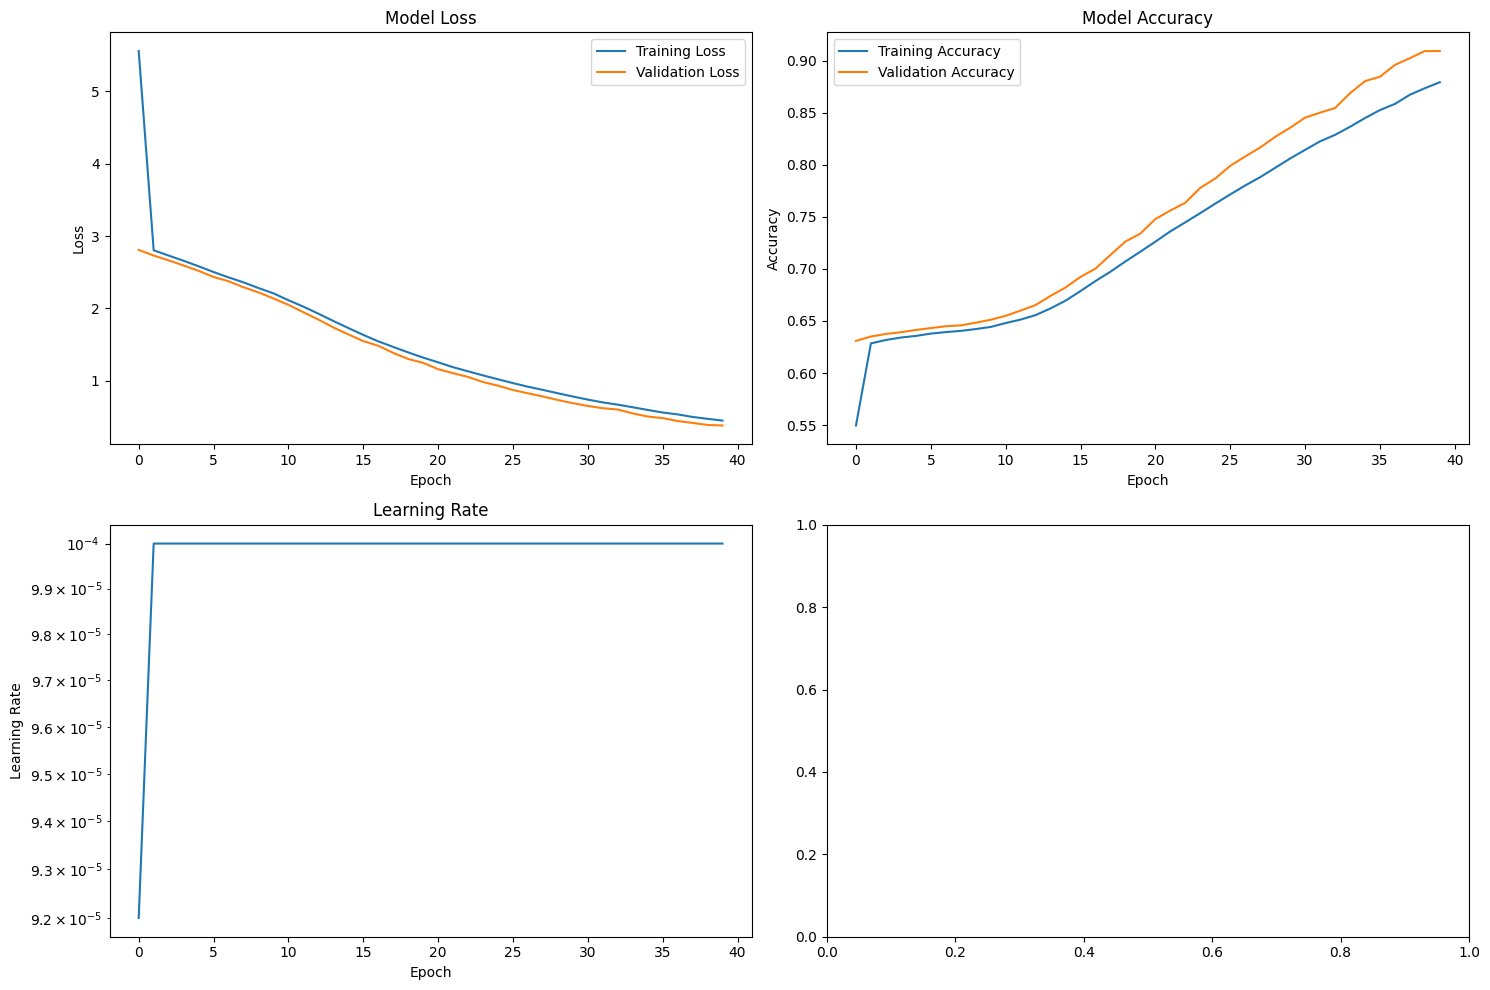

Creating inference models...
Saving models...


In [11]:
print("Loading and preprocessing data...")
# Load data
df = load_data("dataset")
print("Original Dataset:\n")
print(df.head())
print(df.info())

# Preprocess with augmentation
augmented_data = []
for _, row in df.iterrows():
    pairs = advanced_augment_data(row['question'], row['answer'])
    augmented_data.extend(pairs)

df_augmented = pd.DataFrame(augmented_data, columns=['question', 'answer'])

# Rest of your preprocessing steps
q_data, a_data, q_tokenizer, a_tokenizer = preprocess_data(df_augmented)
print("Dataset after preprocessing and augmentation:\n")
print(df_augmented.head())
print(df_augmented.info())

# Split data
indices = np.arange(len(q_data))
np.random.shuffle(indices)
q_data = q_data[indices]
a_data = a_data[indices]

num_val = int(len(q_data) * VALIDATION_SPLIT)
num_test = int(len(q_data) * TEST_SPLIT)

q_train = q_data[:-num_val-num_test]
a_train = a_data[:-num_val-num_test]
q_val = q_data[-num_val-num_test:-num_test]
a_val = a_data[-num_val-num_test:-num_test]
q_test = q_data[-num_test:]
a_test = a_data[-num_test:]

print("Building model...")
# Build model
model = build_improved_model(len(q_tokenizer.word_index) + 1, len(a_tokenizer.word_index) + 1)

print("Training model...")
# Train model
history = model.fit(
    [q_train, a_train[:, :-1]],
    a_train[:, 1:],
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=([q_val, a_val[:, :-1]], a_val[:, 1:]),
    callbacks=callbacks
)

# Plot training history
print("Plotting training history...")
plot_training_history(history)

# Create inference models
print("Creating inference models...")
encoder_model, decoder_model = create_inference_models(model, len(a_tokenizer.word_index) + 1)

# Save models
print("Saving models...")
model.save('full_model.keras')
encoder_model.save('encoder_model.keras')
decoder_model.save('decoder_model.keras')

In [16]:
tf.keras.config.enable_unsafe_deserialization()

# Load the encoder and decoder separately
encoder_model = load_model('encoder_model.keras', custom_objects=custom_objects)
decoder_model = load_model('decoder_model.keras', custom_objects=custom_objects)

# Evaluate model
print("Evaluating model...")
bleu_scores, rouge_scores = evaluate_model_advanced(
    encoder_model, decoder_model,
    q_test, a_test,
    q_tokenizer, a_tokenizer,
    beam_width=BEAM_WIDTH,
    temperature=TEMPERATURE
)

# Print results
print("\nEvaluation Results:")
for metric, score in bleu_scores.items():
    print(f"{metric.upper()}: {score:.4f}")
for metric, score in rouge_scores.items():
    print(f"{metric.upper()}: {score:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'attention_decoder_layer', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'attention_decoder_layer' (of type AttentionDecoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Evaluating model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'bahdanau_attention_1' (of type BahdanauAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'functional_2' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(



Evaluation Results:
BLEU_1: 0.0237
BLEU_2: 0.0056
BLEU_3: 0.0012
BLEU_4: 0.0005
ROUGE1: 0.0381
ROUGE2: 0.0035
ROUGEL: 0.0372
